# CSE 158R Assignment 2

**Keyu Long, Man Jiang**

Dataset: https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_local

Citation:

Translation-based factorization machines for sequential recommendation Rajiv Pasricha, Julian McAuley RecSys, 2018 pdf

Translation-based recommendation Ruining He, Wang-Cheng Kang, Julian McAuley RecSys, 2017 pdf

In [1]:
# Intel Speedup
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# utils
import os
import gzip
from collections import defaultdict
from tqdm import tqdm as progress_bar
import re
from wordcloud import WordCloud, STOPWORDS

In [3]:
# foundation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(display="diagram")

In [63]:
# data preprocess
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

In [324]:
# models
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

In [184]:
# evaluations
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [313]:
# helper methods
def plot_cm(y_test, y_test_pred, name):
    cm = confusion_matrix(y_test, y_test_pred)
    labels = [1, 2, 3, 4, 5]
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_df, annot=True, cmap=plt.get_cmap('Blues'), fmt="d")
    plt.title("Confusion Matrix of " + name)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

# Loading Data

### First clean the data

In [7]:
%%time 
# this cell organize user's position and decide the valid user we wish to use
user_position = defaultdict(tuple)
valid_user = set()
with gzip.open('users.clean.json.gz') as f:
    for l in progress_bar(f):
        temp = eval(l)
        # if current address exist
        if temp['currentPlace'] is not None and len(temp['currentPlace']) == 2:
            # get and clean the user position data
            position_a = temp['currentPlace'][1][1] / 10000000
            position_b = temp['currentPlace'][1][2] / 10000000
            # use usa coordication to filter out usa users
            if position_a >= 25 and position_a <= 50: 
                if position_b >= -124 and position_b <= -67:
                    user_position[temp['gPlusUserId']] = (position_a, position_b)
                    valid_user.add(temp['gPlusUserId'])

3747937it [02:20, 26758.48it/s]

CPU times: total: 2min 19s
Wall time: 2min 20s


In [11]:
%%time 
# this cell organize place's gps, and decide the valid place we wish to use
place_gps = defaultdict(tuple)
valid_place = set()
with gzip.open('places.clean.json.gz') as f:
    for l in progress_bar(f):
        temp = eval(l)
        # we only want to opened business with location
        if temp['closed'] == False and temp['gps'] is not None:
            position_a = temp['gps'][0]
            position_b = temp['gps'][1]
            # use usa coordication to filter out usa business
            if position_a >= 25 and position_a <= 50: 
                if position_b >= -124 and position_b <= -67:
                    valid_place.add(temp['gPlusPlaceId'])
                    place_gps[temp['gPlusPlaceId']] = (position_a, position_b)

3114353it [02:25, 21434.83it/s]

CPU times: total: 2min 25s
Wall time: 2min 25s


In [12]:
len(valid_user), len(valid_place)

(358215, 1264549)

In [13]:
%%time
# this cell record the reviews information (in the valid pairs)
X_full = []
y_full = []
with gzip.open('reviews.clean.json.gz') as f:
    for l in progress_bar(f):
        temp = eval(l)
        user = temp['gPlusUserId']
        place = temp['gPlusPlaceId']
        rating = temp['rating']
        review = temp['reviewText']
        if user in valid_user and place in valid_place:
            if review is not None:
                X_full.append((user, place, review))
                y_full.append(rating)

11453845it [05:26, 35106.21it/s]

CPU times: total: 5min 25s
Wall time: 5min 26s


## Data Preprocess

In [53]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.1, random_state=42)

In [54]:
# get the train data average ratings for user & place
ratings_per_user = defaultdict(list)
ratings_per_place = defaultdict(list)
overall_ratings = []

for (user, place, review), rating in zip(X_train, y_train):
    ratings_per_user[user].append(rating)
    ratings_per_place[place].append(rating)
    overall_ratings.append(rating)
    
average_rating = np.mean(overall_ratings)

In [55]:
def feature(user, place, review, ratings_per_user=ratings_per_user, ratings_per_place=ratings_per_place):
    """
    This method that returns the features.
    
    input:
        user_id
        place_id
    output:
        user_position_a, 
        user_position_b, 
        average_user_ratings
        place_position_a, 
        place_position_b, 
        average_place_ratings,
        place_name
    """
    # provide the data with the keys
    output = [user, place]
    
    # get the user positions
    user_position_a, user_position_b = user_position[user]
    output.append(user_position_a)
    output.append(user_position_b)
    
    # get the average user ratings
    if user in ratings_per_user:
        output.append(np.mean(ratings_per_user[user]))
    else:
        output.append(average_rating)
        
    # get the place positions
    place_position_a, place_position_b = place_gps[place]
    output.append(place_position_a)
    output.append(place_position_b)
    
    # get the average place ratings
    if place in ratings_per_place:
        output.append(np.mean(ratings_per_place[place]))
    else:
        output.append(average_rating)
        
    # append the review
    output.append(review)
        
#     # append the place_name
#     name = place_name[place]
#     output.append(name)
    
    return output

In [56]:
%%time
X_train_final = []
for user, place, review in progress_bar(X_train):
    X_train_final.append(feature(user, place, review))

100%|███████████████████████████████████████████████████████████████████████| 740935/740935 [00:12<00:00, 57722.95it/s]

CPU times: total: 12.9 s
Wall time: 13 s


In [57]:
%%time
X_test_final = []
for user, place, review in progress_bar(X_test):
    X_test_final.append(feature(user, place, review))

100%|█████████████████████████████████████████████████████████████████████████| 82327/82327 [00:01<00:00, 48333.66it/s]

CPU times: total: 1.72 s
Wall time: 1.72 s


In [74]:
# organize the data into pds and append the column name
column_names = ['user', 'place', 'user_pa', 'user_pb', 'user_avg', 'place_pa', 'place_pb', 'place_avg', 'review_text']
X_train_final_df = pd.DataFrame(X_train_final, columns=column_names)
y_train = pd.Series(np.array(y_train), dtype=int) - 1
X_test_final_df = pd.DataFrame(X_test_final, columns=column_names)
y_test = pd.Series(np.array(y_test), dtype=int) - 1

In [443]:
len(X_train), len(X_test)

(740935, 82327)

## EDA

### Average Ratings On Map

In [76]:
X_train_final_df.head()

user                  place    user_pa     user_pb  \
0  112747775897922746855  115345501799087214145  26.142036  -81.794810   
1  112108530395925987205  109868301260538248304  45.523875 -122.670399   
2  114164542486348209726  106424779473844640051  42.368370  -83.352710   
3  110464086750233065281  108585805420557317096  39.916624  -75.183722   
4  104842036775200962436  106721702006366108822  38.895112  -77.036366   

   user_avg   place_pa    place_pb  place_avg  \
0   4.50000  26.207638  -81.766852   5.000000   
1   5.00000  45.490227 -122.796389   4.187500   
2   3.69375  42.413481  -83.432664   2.000000   
3   5.00000  39.939143  -75.175764   4.833333   
4   3.90411  38.894177  -77.023451   4.000000   

                                         review_text  
0                                 Love this place :)  
1  Thank you Carr Subaru staff for your help! We ...  
2  I first went here several months ago while thi...  
3  CrossFit Supercharged has become my second hom...  
4  Stopped here for breakfast and it's a great sp...

In [119]:
coordination_place = \
    X_train_final_df.astype({'place_pa': int, 'place_pb': int}).groupby(['place_pa', 'place_pb'])[['place_avg']]. \
    mean().reset_index()
coordination_user = \
    X_train_final_df.astype({'user_pa': int, 'user_pb': int}).groupby(['user_pa', 'user_pb'])[['user_avg']]. \
    mean().reset_index()

<AxesSubplot: title={'center': 'Business Average Ratings'}, xlabel='place_pb', ylabel='place_pa'>

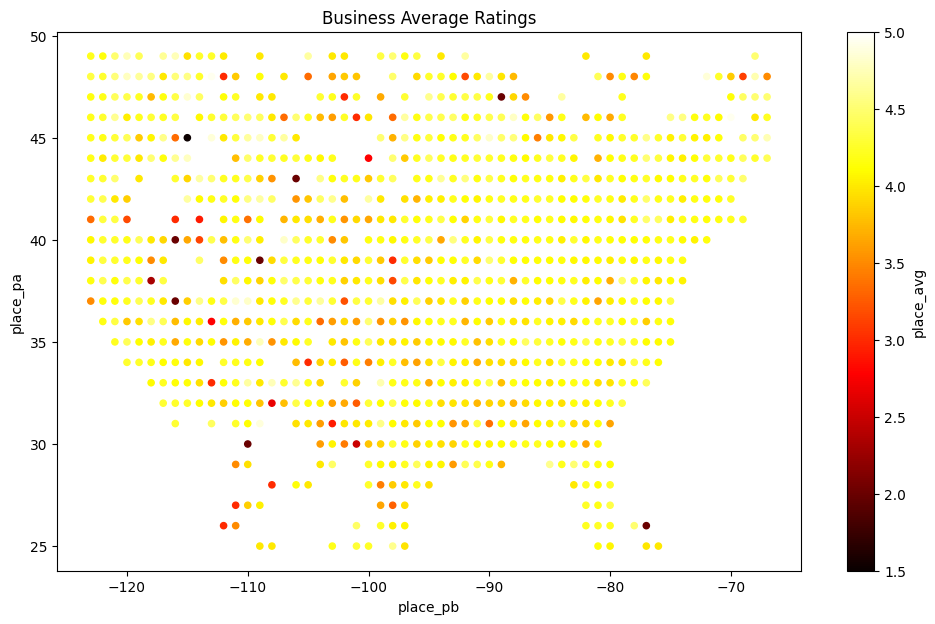

In [120]:
coordination_place.plot(kind='scatter', x='place_pb', y='place_pa', alpha=1, figsize=(12, 7),
                     c = "place_avg", cmap=plt.get_cmap('hot'), colorbar=True, title="Business Average Ratings")

<AxesSubplot: title={'center': 'User Average Ratings'}, xlabel='user_pb', ylabel='user_pa'>

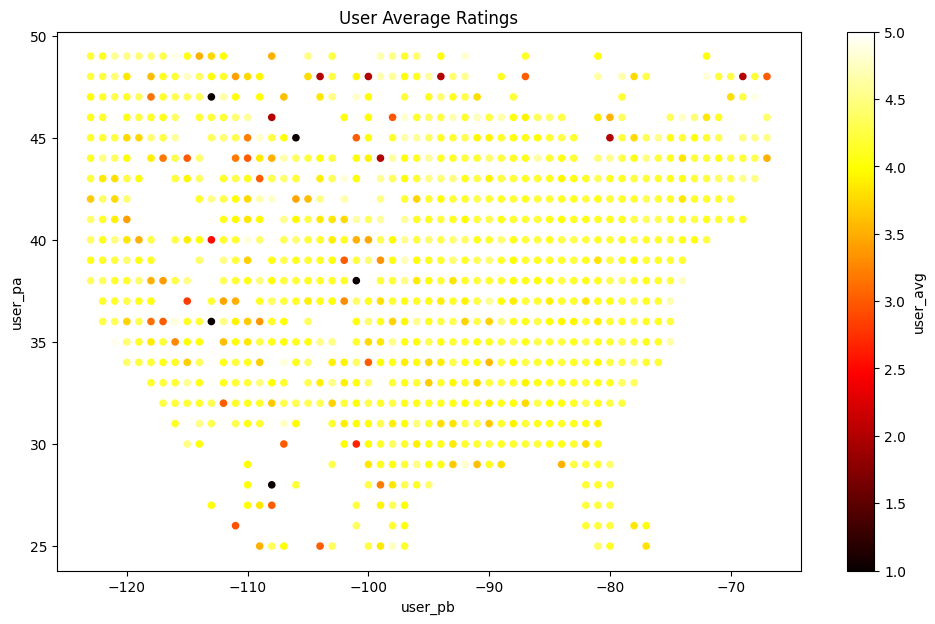

In [122]:
coordination_user.plot(kind='scatter', x='user_pb', y='user_pa', alpha=1, figsize=(12, 7),
                     c = "user_avg", cmap=plt.get_cmap('hot'), colorbar=True, title="User Average Ratings")

In [86]:
place_with_avg = X_train_final_df.groupby('place')[['place_avg', 'place_pa', 'place_pb']].mean()
user_with_avg = X_train_final_df.groupby('user')[['user_avg', 'user_pa', 'user_pb']].mean()

<AxesSubplot: title={'center': 'Business Average Ratings'}, xlabel='place_pb', ylabel='place_pa'>

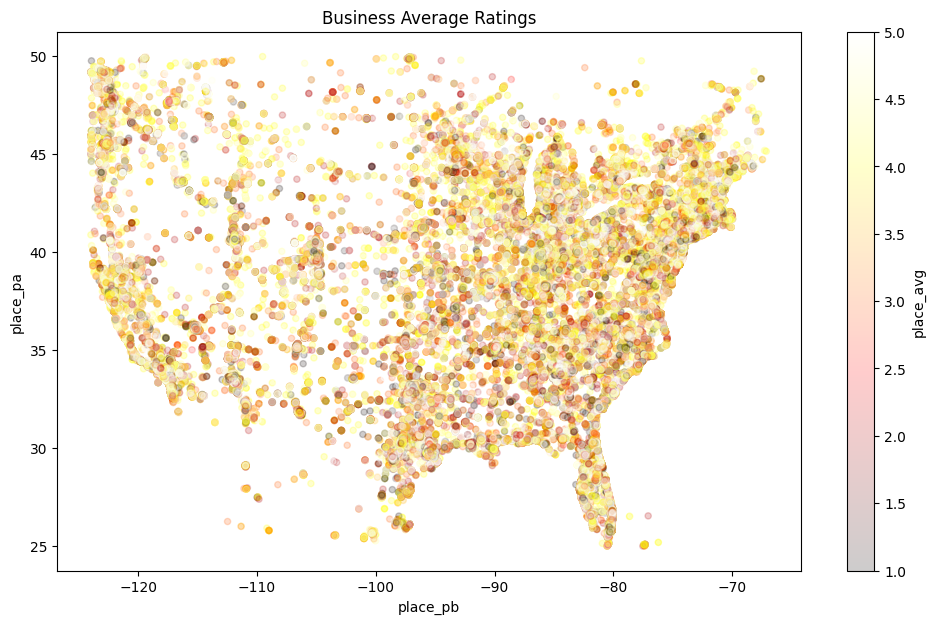

In [85]:
place_with_avg.plot(kind='scatter', x='place_pb', y='place_pa', alpha=0.2, figsize=(12, 7),
                     c = "place_avg", cmap=plt.get_cmap('hot'), colorbar=True, title="Business Average Ratings")

<AxesSubplot: title={'center': 'User Average Ratings'}, xlabel='user_pb', ylabel='user_pa'>

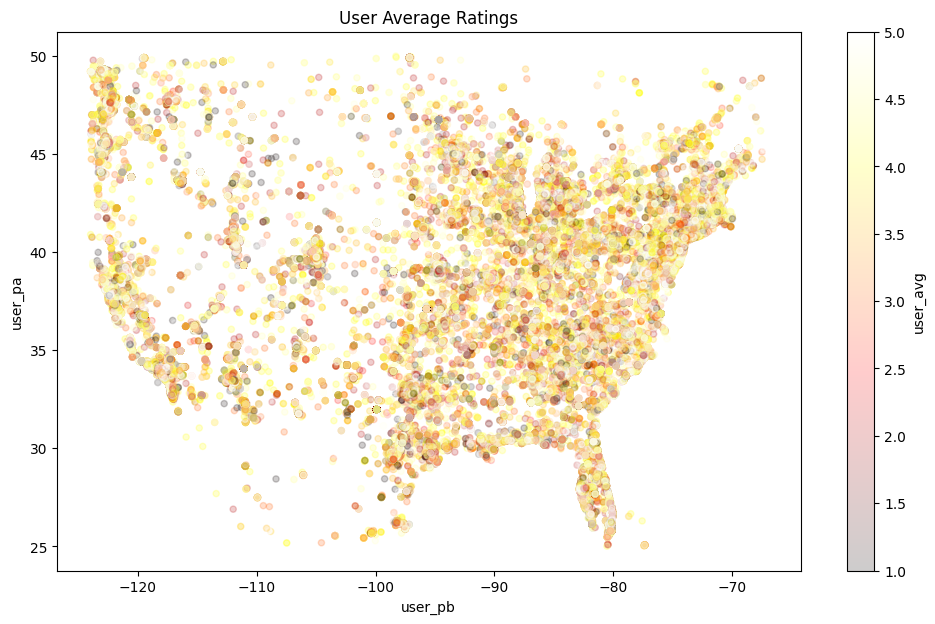

In [87]:
user_with_avg.plot(kind='scatter', x='user_pb', y='user_pa', alpha=0.2, figsize=(12, 7),
                     c = "user_avg", cmap=plt.get_cmap('hot'), colorbar=True, title="User Average Ratings")

### Ratings Basic Statistics

In [96]:
y_train = pd.DataFrame(y_train, columns=['ratings'])

array([[<AxesSubplot: title={'center': 'ratings'}>]], dtype=object)

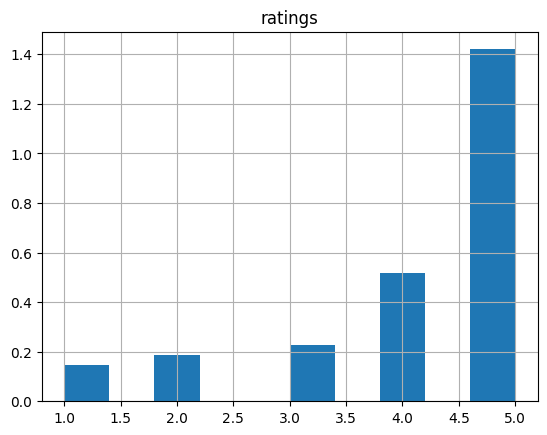

In [97]:
y_train.hist('ratings', density=True)

In [98]:
y_train.describe()

ratings
count  740935.000000
mean        4.151612
std         1.209587
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000

### Word Cloud on Review Text

In [159]:
# a small sample 
X_train_sample = X_train_final_df.sample(10000)

In [156]:
comment_words = ''
stopwords = set(STOPWORDS)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.96it/s]


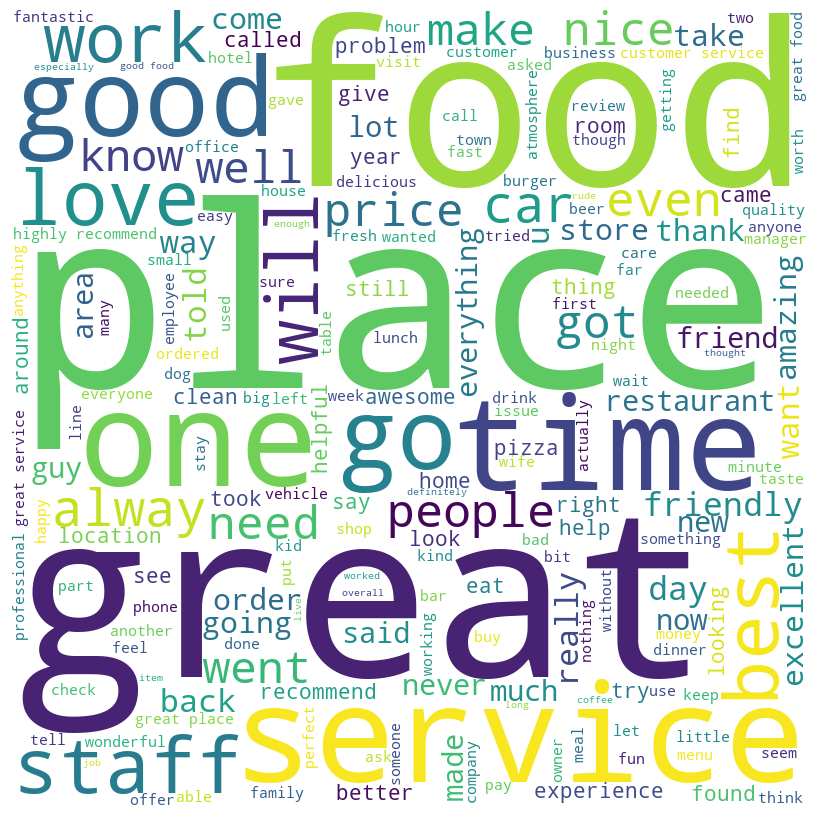

In [160]:
for review in progress_bar(X_train_sample['review_text']):
    review = str(review) 
    tokens = review.split() # split
    # lower character
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens) + " "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Model
## Baseline

In [423]:
# drop the id information
X_train = X_train_final_df.drop(['user', 'place'], axis=1)
X_test = X_test_final_df.drop(['user', 'place'], axis=1)

In [434]:
# Must do PCA before feeding the TF-IDF Vector into model
preproc1 =  ColumnTransformer(
    transformers = [
        ('std', StandardScaler(), ['user_pa', 'user_pb', 'user_avg', 'place_pa', 'place_pb', 'place_avg']),
        ('tfidf', TfidfVectorizer(decode_error='ignore'), 'review_text')
    ]
)
preproc2 = ColumnTransformer(
    transformers = [
        ('std', StandardScaler(with_mean=False), [0, 1, 2, 3, 4, 5]) # those are 6 previous predictor
    ], remainder = TruncatedSVD(100)
)
transformer = Pipeline([
    ('preprocessor1', preproc1),
    ('preprocessor2', preproc2)
])

In [435]:
ridge = Pipeline([
    ('transformer', transformer),
    ('rig_clf', LogisticRegression(n_jobs=-1, class_weight='balanced'))
])

In [436]:
ridge.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\iaat\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer',
                 Pipeline(steps=[('preprocessor1',
                                  ColumnTransformer(transformers=[('std',
                                                                   StandardScaler(),
                                                                   ['user_pa',
                                                                    'user_pb',
                                                                    'user_avg',
                                                                    'place_pa',
                                                                    'place_pb',
                                                                    'place_avg']),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(decode_error='ignore'),
                                                                   'review_text')])),
                                 ('preprocessor2',
                                  ColumnTransformer(remainder=TruncatedSVD(n_components=100),
                                                    transformers=[('std',
                                                                   StandardScaler(with_mean=False),
                                                                   [0, 1, 2, 3,
                                                                    4,
                                                                    5])]))])),
                ('rig_clf',
                 LogisticRegression(class_weight='balanced', n_jobs=1))])

In [437]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [438]:
# train accuracy
accuracy_score(y_train, y_train_pred)

0.7698637532307152

In [439]:
# test accuracy
accuracy_score(y_test, y_test_pred)

0.47941744506662454

In [440]:
# train balanced accuracy score
balanced_accuracy_score(y_train, y_train_pred)

0.6849376966541738

In [441]:
# test balanced accuracy score
balanced_accuracy_score(y_test, y_test_pred)

0.3428139503708372

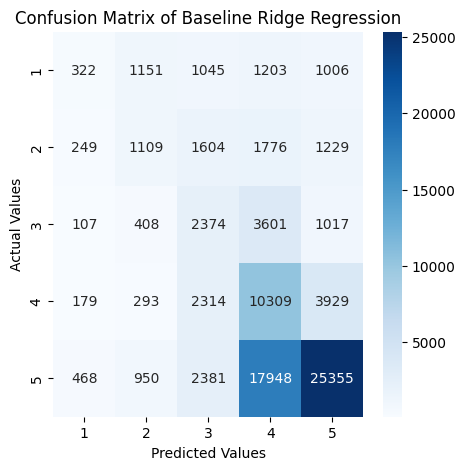

In [442]:
plot_cm(y_test, y_test_pred, "Baseline Ridge Regression")

### PCA with TF-IDF

In [446]:
# discard the average score
X_train = X_train.drop(['user_avg', 'place_avg'], axis=1)
X_test = X_test.drop(['user_avg', 'place_avg'], axis=1)

In [447]:
# PCA before feeding the TF-IDF Vector into model: LSA
preproc1 =  ColumnTransformer(
    transformers = [
        ('std', StandardScaler(), ['user_pa', 'user_pb', 'place_pa', 'place_pb']),
        ('tfidf', TfidfVectorizer(decode_error='ignore'), 'review_text')
    ]
)
preproc2 = ColumnTransformer(
    transformers = [
        ('std', StandardScaler(with_mean=False), [0, 1, 2, 3]) # those are 6 previous predictor
    ], remainder = TruncatedSVD(100)
)
transformer = Pipeline([
    ('preprocessor1', preproc1),
    ('preprocessor2', preproc2)
])

## Logistic Regression

In [456]:
log = Pipeline([
    ('transformer', transformer),
    ('log_clf', LogisticRegression(n_jobs=-1, class_weight='balanced'))
])

In [457]:
log.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\iaat\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer',
                 Pipeline(steps=[('preprocessor1',
                                  ColumnTransformer(transformers=[('std',
                                                                   StandardScaler(),
                                                                   ['user_pa',
                                                                    'user_pb',
                                                                    'place_pa',
                                                                    'place_pb']),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(decode_error='ignore'),
                                                                   'review_text')])),
                                 ('preprocessor2',
                                  ColumnTransformer(remainder=TruncatedSVD(n_components=100),
                                                    transformers=[('std',
                                                                   StandardScaler(with_mean=False),
                                                                   [0, 1, 2,
                                                                    3])]))])),
                ('log_clf',
                 LogisticRegression(class_weight='balanced', n_jobs=1))])

In [458]:
y_train_pred = log.predict(X_train)
y_test_pred = log.predict(X_test)

In [459]:
# train accuracy
accuracy_score(y_train, y_train_pred)

0.5521307537098396

In [460]:
# test accuracy
accuracy_score(y_test, y_test_pred)

0.5534636267567141

In [461]:
# train balanced accuracy score
balanced_accuracy_score(y_train, y_train_pred)

0.4845570023964262

In [462]:
# test balanced accuracy score
balanced_accuracy_score(y_test, y_test_pred)

0.4828160240503207

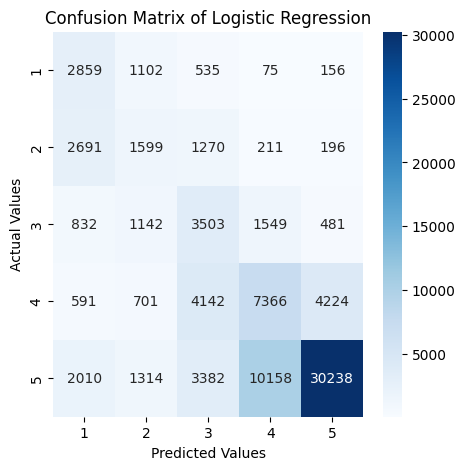

In [463]:
plot_cm(y_test, y_test_pred, "Logistic Regression")

## Random Forest

In [448]:
random_forest = Pipeline([
    ('transformer', transformer),
    ('rdf_clf', RandomForestClassifier(max_depth = 10, n_jobs=-1, class_weight='balanced'))
])

In [449]:
random_forest.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('preprocessor1',
                                  ColumnTransformer(transformers=[('std',
                                                                   StandardScaler(),
                                                                   ['user_pa',
                                                                    'user_pb',
                                                                    'place_pa',
                                                                    'place_pb']),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(decode_error='ignore'),
                                                                   'review_text')])),
                                 ('preprocessor2',
                                  ColumnTransformer(remainder=TruncatedSVD(n_components=100),
                                                    transformers=[('std',
                                                                   StandardScaler(with_mean=False),
                                                                   [0, 1, 2,
                                                                    3])]))])),
                ('rdf_clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_jobs=-1))])

In [450]:
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

In [451]:
# train accuracy
accuracy_score(y_train, y_train_pred)

0.45812790595666286

In [452]:
# test accuracy
accuracy_score(y_test, y_test_pred)

0.4423943542215798

In [453]:
# train balanced accuracy score
balanced_accuracy_score(y_train, y_train_pred)

0.4671688931998011

In [454]:
# test balanced accuracy score
balanced_accuracy_score(y_test, y_test_pred)

0.4349359934123422

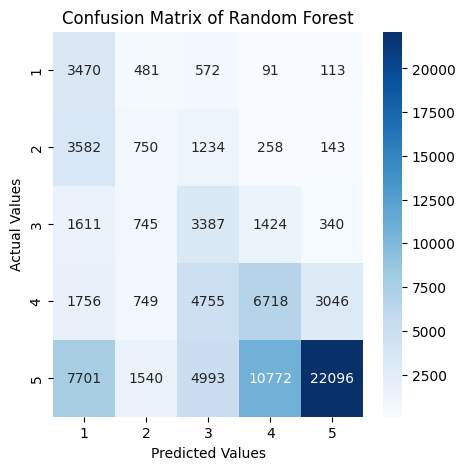

In [455]:
plot_cm(y_test, y_test_pred, "Random Forest")

### Feature Importance

In [479]:
columns = ['user_pa', 'user_pb', 'place_pa', 'place_pb'] + list(range(100))
forest_importances = pd.Series(random_forest['rdf_clf'].feature_importances_, index = columns)
std = np.std([tree.feature_importances_ for tree in (random_forest['rdf_clf'].estimators_)], axis=0)

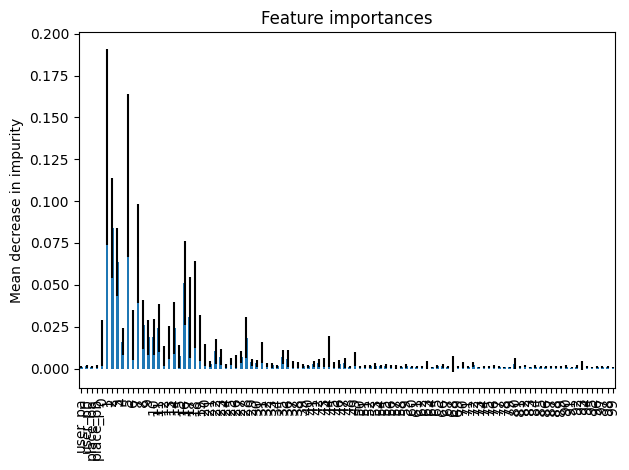

In [501]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## MLP

In [404]:
from sklearn.neural_network import MLPClassifier

In [405]:
mlp = Pipeline([
    ('transformer', transformer),
    ('mlp_clf', MLPClassifier((64, 16)))
])

In [406]:
mlp.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('preprocessor1',
                                  ColumnTransformer(transformers=[('std',
                                                                   StandardScaler(),
                                                                   ['user_pa',
                                                                    'user_pb',
                                                                    'place_pa',
                                                                    'place_pb']),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(decode_error='ignore'),
                                                                   'review_text')])),
                                 ('preprocessor2',
                                  ColumnTransformer(remainder=TruncatedSVD(n_components=100),
                                                    transformers=[('std',
                                                                   StandardScaler(with_mean=False),
                                                                   [0, 1, 2,
                                                                    3])]))])),
                ('mlp_clf', MLPClassifier(hidden_layer_sizes=(64, 16)))])

In [407]:
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

In [408]:
# train accuracy
accuracy_score(y_train, y_train_pred)

0.6579052143575347

In [409]:
# test accuracy
accuracy_score(y_test, y_test_pred)

0.6537102044286808

In [410]:
# train balanced accuracy score
balanced_accuracy_score(y_train, y_train_pred)

0.4601448958253491

In [411]:
# test balanced accuracy score
balanced_accuracy_score(y_test, y_test_pred)

0.45052786395732924

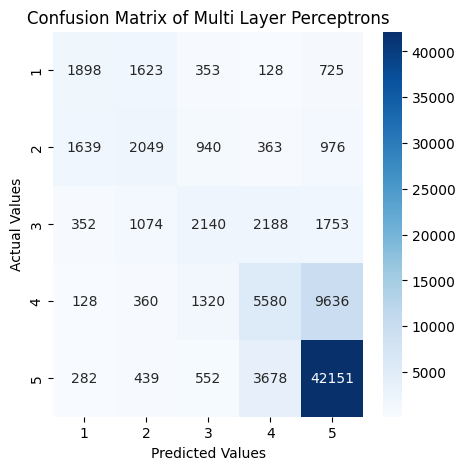

In [413]:
plot_cm(y_test, y_test_pred, "Multi Layer Perceptrons")